# SSL Models Performance Analysis on SurgVU Dataset

This notebook analyzes the performance of Self-Supervised Learning (SSL) models trained on the SurgVU dataset.

## Data Sources:
1. **train_val_results.csv** - validation results during training
2. **test_results.csv** - evaluation results on test set

## Models:
- **ImageNet** - weights pre-trained on ImageNet
- **MoCo** - Momentum Contrast 
- **SimCLR** - Simple Contrastive Learning

## Data Subsets:
- **12.5%** - 1/8 of training data
- **25%** - 1/4 of training data  
- **100%** - full training data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

print("📊 SSL Models Performance Analysis on SurgVU Dataset")
print("="*60)

📊 SSL Models Performance Analysis on SurgVU Dataset


## 1. Data Loading and Preparation

In [5]:
# Paths to CSV files in results subdirectory
train_val_file = "../../results/train_val_results.csv"
test_eval_file = "../../results/test_results.csv"

# Check if files exist
print("🔍 Checking files:")
print(f"Train/Val results: {os.path.exists(train_val_file)} - {train_val_file}")
print(f"Test eval results: {os.path.exists(test_eval_file)} - {test_eval_file}")

# Load data
print("\n📁 Loading data...")

# 1. Training/validation data
df_train_val = pd.read_csv(train_val_file)
print(f"✅ Train/Val data: {df_train_val.shape[0]} rows, {df_train_val.shape[1]} columns")

# 2. Test data
df_test = pd.read_csv(test_eval_file)
print(f"✅ Test data: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

print("\n📋 Data preview:")
print("\n--- Train/Val Results ---")
print(df_train_val.head())
print("\n--- Test Evaluation Results ---")
print(df_test.head())

🔍 Checking files:
Train/Val results: True - ../../results/train_val_results.csv
Test eval results: True - ../../results/test_results.csv

📁 Loading data...
✅ Train/Val data: 9 rows, 14 columns
✅ Test data: 9 rows, 10 columns

📋 Data preview:

--- Train/Val Results ---
      model data_subset              job_directory  \
0  ImageNet       12.5%  job_1952602_20251015_1437   
1  ImageNet         25%  job_1952603_20251015_1437   
2  ImageNet        100%  job_1952604_20251015_1437   
3      MoCo       12.5%  job_1953621_20251016_1141   
4      MoCo         25%  job_1953622_20251016_1141   

                                            job_path  \
0  /net/tscratch/people/plgjmachali/surgvu_result...   
1  /net/tscratch/people/plgjmachali/surgvu_result...   
2  /net/tscratch/people/plgjmachali/surgvu_result...   
3  /net/tscratch/people/plgjmachali/surgvu_result...   
4  /net/tscratch/people/plgjmachali/surgvu_result...   

                                     checkpoint_path  checkpoint_exis

In [6]:
# Rename columns for clarity: test_* -> val_* (these are validation results, not test results)
print("🔧 Data preparation...")
print("📝 Renaming columns for clarity: test_* -> val_*")

# Rename validation columns in train_val data
df_train_val = df_train_val.rename(columns={
    'test_f1_macro': 'val_f1_macro',
    'test_f1_weighted': 'val_f1_weighted', 
    'test_accuracy': 'val_accuracy'
})

# Prepare test data - remove unnecessary columns
df_test_clean = df_test[['model', 'data_subset', 'phase', 'test_f1_macro', 'test_f1_weighted', 'test_accuracy']].copy()

# Normalize model names (if needed)
model_mapping = {
    'ImageNet': 'ImageNet',
    'MoCo': 'MoCo', 
    'SimCLR': 'SimCLR'
}

# Define consistent colors for all models across all visualizations
model_colors = {'ImageNet': '#1f77b4', 'MoCo': '#ff7f0e', 'SimCLR': '#2ca02c'}
print("🎨 Defined consistent color scheme:")
for model, color in model_colors.items():
    print(f"  {model}: {color}")

# Set category order for X-axis
subset_order = ["12.5%", "25%", "100%"]
df_train_val["data_subset"] = pd.Categorical(df_train_val["data_subset"], categories=subset_order, ordered=True)
df_test_clean["data_subset"] = pd.Categorical(df_test_clean["data_subset"], categories=subset_order, ordered=True)

# Check unique values
print(f"\n📊 Models in train/val: {df_train_val['model'].unique()}")
print(f"📊 Models in test: {df_test_clean['model'].unique()}")
print(f"📊 Data subsets: {subset_order}")
print(f"✅ Column renaming completed - now using: val_f1_macro, val_f1_weighted, val_accuracy")

🔧 Data preparation...
📝 Renaming columns for clarity: test_* -> val_*
🎨 Defined consistent color scheme:
  ImageNet: #1f77b4
  MoCo: #ff7f0e
  SimCLR: #2ca02c

📊 Models in train/val: ['ImageNet' 'MoCo' 'SimCLR']
📊 Models in test: ['ImageNet' 'MoCo' 'SimCLR']
📊 Data subsets: ['12.5%', '25%', '100%']
✅ Column renaming completed - now using: val_f1_macro, val_f1_weighted, val_accuracy


In [7]:
df_test_clean

,model,data_subset,phase,test_f1_macro,test_f1_weighted,test_accuracy
0,ImageNet,12.5%,0,53.222131,65.754207,63.3804
1,ImageNet,25%,0,56.474658,74.104327,75.8246
2,ImageNet,100%,0,65.188500,78.838536,78.5186
3,MoCo,12.5%,0,56.920143,73.685535,73.0514
4,MoCo,25%,0,62.085538,77.095946,77.6118
5,MoCo,100%,0,67.176518,80.956114,80.3307
6,SimCLR,12.5%,0,57.711273,74.034684,73.7025
7,SimCLR,25%,0,62.774589,77.676492,77.3293
8,SimCLR,100%,0,65.364192,80.222635,79.7666


## 2. Validation Results Visualization (Train/Val)

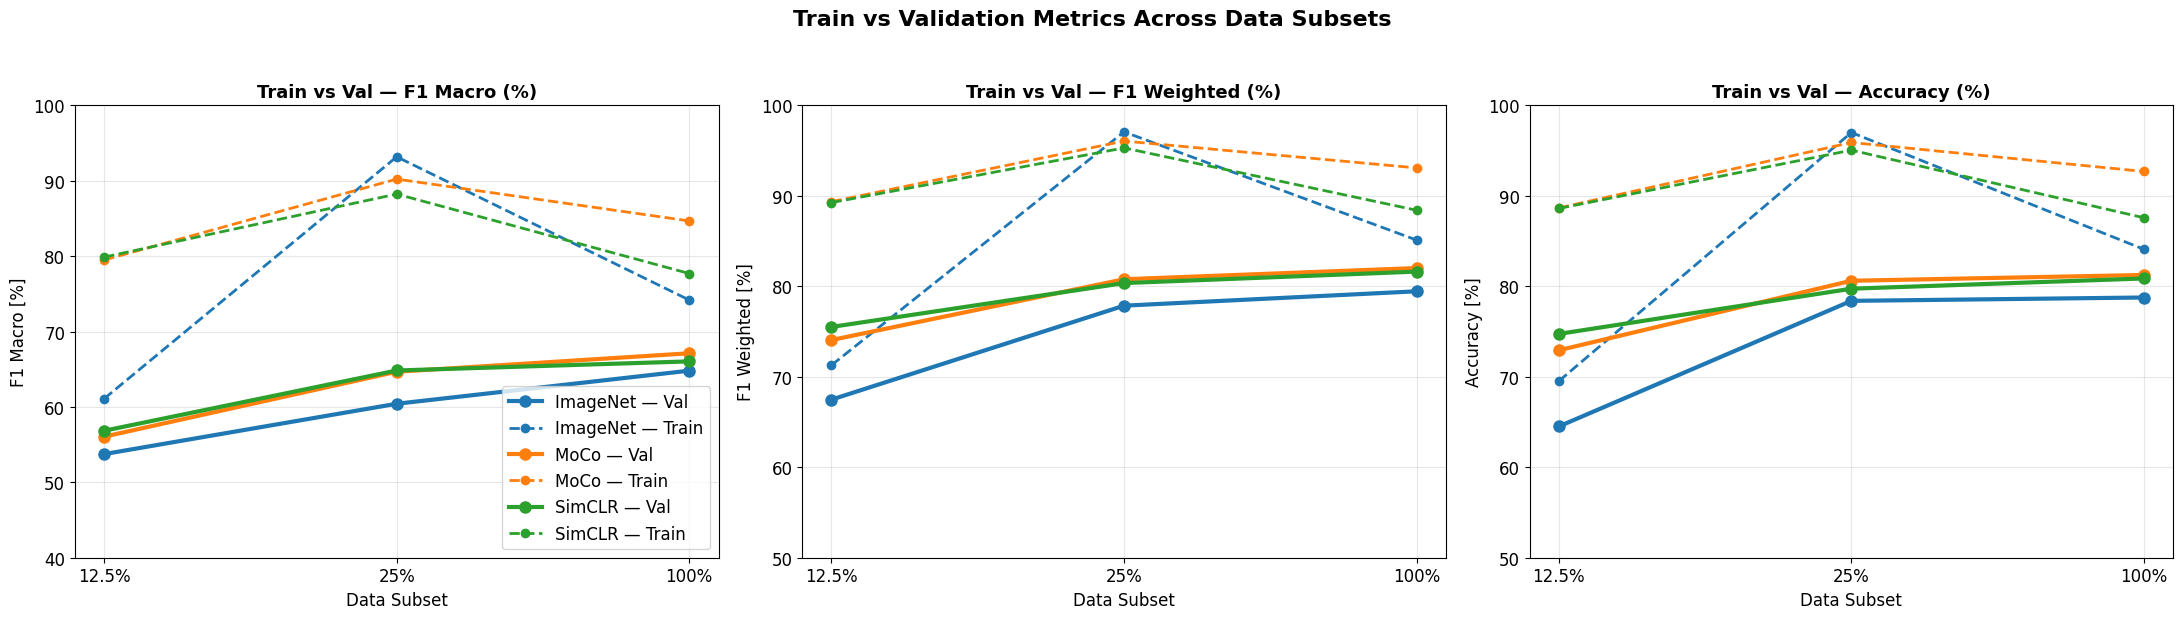

In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Consistent model colours ---
model_colors = {'ImageNet': '#1f77b4', 'MoCo': '#ff7f0e', 'SimCLR': '#2ca02c'}

# --- Prepare subset ordering ---
def subset_to_float(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    m = re.search(r"[\d\.]+", str(x))
    return float(m.group()) if m else np.nan

df = df_train_val.copy()
df["subset_num"] = df["data_subset"].apply(subset_to_float)
cat_labels = (
    df.sort_values("subset_num")["data_subset"]
      .dropna().astype(str).drop_duplicates().tolist()
)
df["data_subset"] = pd.Categorical(df["data_subset"], categories=cat_labels, ordered=True)

# --- Helper: plot Train vs Val for a metric ---
def plot_train_vs_val(ax, title, train_col, val_col, y_label, ylim=None, show_legend=False):
    for model, group in df.groupby("model"):
        g = group.sort_values("data_subset")
        color = model_colors.get(model, None)

        # Val (solid)
        if val_col in g:
            ax.plot(
                g["data_subset"], g[val_col],
                marker="o", linewidth=3, markersize=8,
                label=f"{model} — Val", color=color
            )
        # Train (dashed)
        if train_col in g:
            ax.plot(
                g["data_subset"], g[train_col],
                marker="o", linewidth=2, markersize=6,
                linestyle="--",
                label=f"{model} — Train", color=color
            )

    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_xlabel("Data Subset")
    ax.set_ylabel(y_label)
    ax.grid(True, alpha=0.3)
    if ylim:
        ax.set_ylim(*ylim)
    if show_legend:
        ax.legend()

# --- Combined 3×1 row ---
plt.figure(figsize=(22, 6))

# 1) F1 Macro
ax1 = plt.subplot(1, 3, 1)
plot_train_vs_val(
    ax1,
    title="Train vs Val — F1 Macro (%)",
    train_col="train_f1_macro",
    val_col="val_f1_macro",
    y_label="F1 Macro [%]",
    ylim=(40, 100),
    show_legend=True
)

# 2) F1 Weighted
ax2 = plt.subplot(1, 3, 2)
plot_train_vs_val(
    ax2,
    title="Train vs Val — F1 Weighted (%)",
    train_col="train_f1_weighted",
    val_col="val_f1_weighted",
    y_label="F1 Weighted [%]",
    ylim=(50, 100)
)

# 3) Accuracy
ax3 = plt.subplot(1, 3, 3)
plot_train_vs_val(
    ax3,
    title="Train vs Val — Accuracy (%)",
    train_col="train_accuracy",
    val_col="val_accuracy",
    y_label="Accuracy [%]",
    ylim=(50, 100)
)

plt.suptitle("Train vs Validation Metrics Across Data Subsets", fontsize=16, fontweight="bold", y=1.03)
plt.tight_layout()
plt.show()

In [9]:
df_train_val

,model,data_subset,job_directory,job_path,checkpoint_path,checkpoint_exists,best_phase,best_train_phase,val_f1_macro,val_f1_weighted,val_accuracy,train_f1_macro,train_f1_weighted,train_accuracy
0,ImageNet,12.5%,job_1952602_20251015_1437,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,3,1,53.743988,67.475332,64.5076,61.091678,71.279165,69.5220
1,ImageNet,25%,job_1952603_20251015_1437,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,43,21,60.420523,77.857857,78.3905,93.175345,97.066898,96.9955
2,ImageNet,100%,job_1952604_20251015_1437,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,7,3,64.809127,79.446512,78.7604,74.177257,85.108709,84.0884
3,MoCo,12.5%,job_1953621_20251016_1141,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,5,2,56.055963,74.060891,72.9294,79.487870,89.353593,88.6579
4,MoCo,25%,job_1953622_20251016_1141,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,21,10,64.665731,80.777248,80.6107,90.218185,96.054393,95.8923
5,MoCo,100%,job_1953627_20251016_1145,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,17,8,67.114631,82.013263,81.2507,84.667293,93.083358,92.6894
6,SimCLR,12.5%,job_1952103_20251015_0322,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,5,2,56.839550,75.507024,74.7362,79.870168,89.250412,88.6037
7,SimCLR,25%,job_1952104_20251015_0322,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,21,10,64.832185,80.352568,79.7331,88.233325,95.294949,95.0455
8,SimCLR,100%,job_1952105_20251015_0322,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,5,2,66.040090,81.622776,80.8663,77.692975,88.406387,87.5738


# Conclusions: 

There is a clear sign of overfitting for all models; however, it becomes less pronounced as the training set grows. It is worth noting that, for every model and data subset, the checkpoint with the best validation score was selected. Because of this, the plots do not fully capture how overfitting naturally evolves with increasing dataset size, and the gap between training and validation should be interpreted with caution.

All models achieved their best validation performance (F1 Macro, F1 Weighted, and Accuracy) when trained on 100% of the data, although the improvement from 25% to 100% was relatively small. Self-supervised models (MoCo and SimCLR) consistently outperformed the ImageNet-initialized baseline, particularly when fewer labeled samples were available, highlighting their superior ability to learn effectively from limited data.

In [10]:
# --- PHASE METRICS: COLLECT, ANALYZE, PLOT (no job_id, no iteration) ---

import os, re, json
from pathlib import Path
from typing import List, Tuple, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============== CONFIG ==============
BASE_DIR = Path("../../results/experiments")
TRAINING_DIR = BASE_DIR / "training"
OUT_DIR = BASE_DIR / "analysis"
OUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR_TO_NAME = {
    "imagenet_to_surgvu": "ImageNet",
    "moco_to_surgvu": "MoCo",
    "simclr_to_surgvu": "SimCLR",
}
SUBSETS = ["12", "25", "100"]
SUBSET_LABEL = {"12": "12.5%", "25": "25%", "100": "100%"}
BEST_METRIC = "f1_macro"     # {"f1_macro", "f1_weighted", "accuracy"}
# ===================================


def find_metrics_files(training_dir: Path):
    files = []
    for model_dir in MODEL_DIR_TO_NAME.keys():
        for subset in SUBSETS:
            base = training_dir / model_dir / subset
            if not base.exists():
                print(f"⚠️ Missing directory: {base}")
                continue
            for job in base.iterdir():
                if job.is_dir():
                    metrics_path = job / "metrics.json"
                    if metrics_path.exists():
                        files.append((MODEL_DIR_TO_NAME[model_dir], subset, metrics_path))
    return files


def safe_get_num(d: Dict[str, Any], path: List[str]) -> float:
    """ Extracts a number or returns NaN, handles {'0': value}. """
    cur = d
    for p in path:
        if not isinstance(cur, dict) or p not in cur:
            return np.nan
        cur = cur[p]
    if isinstance(cur, dict) and "0" in cur and isinstance(cur["0"], (int, float)):
        return float(cur["0"])
    if isinstance(cur, (int, float)):
        return float(cur)
    return np.nan


def collect_rows_from_metrics_file(model: str, subset: str, metrics_path: Path) -> List[Dict[str, Any]]:
    by_phase: Dict[int, Dict[str, Any]] = {}
    with metrics_path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue

            phase_key = obj.get("train_phase_idx", obj.get("phase_idx", None))
            if phase_key is None: 
                continue

            try:
                phase = int(phase_key)
            except Exception:
                continue

            row = by_phase.setdefault(phase, {
                "model": model,
                "data_subset": SUBSET_LABEL.get(subset, subset),
                "subset_num": float(subset if subset != "12" else "12.5"),
                "phase": phase,
                "train_f1_macro": np.nan,
                "train_f1_weighted": np.nan,
                "train_accuracy": np.nan,
                "val_f1_macro": np.nan,
                "val_f1_weighted": np.nan,
                "val_accuracy": np.nan,
            })

            # train
            if "train_f1_score_list_meter" in obj or "train_accuracy_list_meter" in obj:
                acc1 = safe_get_num(obj, ["train_f1_score_list_meter", "accuracy"])
                acc2 = safe_get_num(obj, ["train_accuracy_list_meter", "top_1"])
                row["train_accuracy"]     = acc1 if not np.isnan(acc1) else acc2
                row["train_f1_macro"]     = safe_get_num(obj, ["train_f1_score_list_meter", "macro"])
                row["train_f1_weighted"]  = safe_get_num(obj, ["train_f1_score_list_meter", "weighted"])

            # validation
            if "test_f1_score_list_meter" in obj or "test_accuracy_list_meter" in obj:
                vacc1 = safe_get_num(obj, ["test_f1_score_list_meter", "accuracy"])
                vacc2 = safe_get_num(obj, ["test_accuracy_list_meter", "top_1"])
                row["val_accuracy"]     = vacc1 if not np.isnan(vacc1) else vacc2
                row["val_f1_macro"]     = safe_get_num(obj, ["test_f1_score_list_meter", "macro"])
                row["val_f1_weighted"]  = safe_get_num(obj, ["test_f1_score_list_meter", "weighted"])

    return [by_phase[p] for p in sorted(by_phase)]


def collect_all() -> pd.DataFrame:
    files = find_metrics_files(TRAINING_DIR)
    rows = []
    for model, subset, mpath in files:
        rows.extend(collect_rows_from_metrics_file(model, subset, mpath))
    df = pd.DataFrame(rows)

    ordered = [
        "model", "data_subset", "subset_num", "phase",
        "train_f1_macro", "train_f1_weighted", "train_accuracy",
        "val_f1_macro", "val_f1_weighted", "val_accuracy",
    ]
    if df.empty:
        print("⚠️ No rows collected. Check paths and data format.")
        return pd.DataFrame(columns=ordered)

    df = df[ordered]
    df.sort_values(["model", "subset_num", "phase"], inplace=True)
    return df


def compute_best_epochs(df: pd.DataFrame, best_metric: str = "f1_macro") -> pd.DataFrame:
    metric_col = f"val_{best_metric}"
    if df.empty or metric_col not in df.columns:
        return pd.DataFrame(columns=["model","data_subset","best_phase",f"best_val_{best_metric}"])

    tmp = df.copy()
    idx = tmp.groupby(["model", "data_subset"])[metric_col].idxmax()

    best = tmp.loc[idx].copy()
    best.rename(columns={
        "phase": "best_phase",
        metric_col: f"best_val_{best_metric}"
    }, inplace=True)

    keep = ["model","data_subset","best_phase",f"best_val_{best_metric}"]
    return best[keep].sort_values(["model","data_subset"])


def add_generalization_gap(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["gap_macro"] = out["train_f1_macro"] - out["val_f1_macro"]
    out["gap_weighted"] = out["train_f1_weighted"] - out["val_f1_weighted"]
    out["gap_accuracy"] = out["train_accuracy"] - out["val_accuracy"]
    return out


# ------------- RUN -------------
df_all = collect_all()
df_all.to_csv(OUT_DIR / "phase_metrics_all.csv", index=False)

best_df = compute_best_epochs(df_all, best_metric=BEST_METRIC)
best_df.to_csv(OUT_DIR / f"best_epochs__by_{BEST_METRIC}.csv", index=False)

df_gap = add_generalization_gap(df_all)
df_gap.to_csv(OUT_DIR / "phase_metrics_with_gaps.csv", index=False)

print("✅ Done (without job_id & iteration).")
print(f"Saved CSVs to: {OUT_DIR.resolve()}")

✅ Done (without job_id & iteration).
Saved CSVs to: /Users/jmachali/praca_magisterska/SurgVU_SelfSup/results/experiments/analysis


In [11]:
df_all

,model,data_subset,subset_num,phase,train_f1_macro,train_f1_weighted,train_accuracy,val_f1_macro,val_f1_weighted,val_accuracy
0,ImageNet,12.5%,12.5,0,38.368109,43.553211,42.578125,51.458543,61.618439,59.879610
1,ImageNet,12.5%,12.5,1,61.091678,71.279165,69.528150,53.743988,67.475332,64.519346
2,ImageNet,12.5%,12.5,2,69.506753,80.074886,78.831845,53.463066,71.865551,70.966748
3,ImageNet,12.5%,12.5,3,75.431684,85.227575,84.361049,51.402801,70.994230,70.428255
4,ImageNet,12.5%,12.5,4,79.046236,88.381331,87.746466,50.626719,71.081452,70.566051
...,...,...,...,...,...,...,...,...,...,...
445,SimCLR,100%,100.0,45,97.547603,98.928052,98.919404,57.554160,81.897491,82.913297
446,SimCLR,100%,100.0,46,97.483936,98.933531,98.924506,58.644784,82.186193,83.099141
447,SimCLR,100%,100.0,47,97.594509,98.958725,98.950560,58.304240,82.131968,83.065598
448,SimCLR,100%,100.0,48,97.545954,98.950597,98.941997,57.186084,81.970286,82.987635


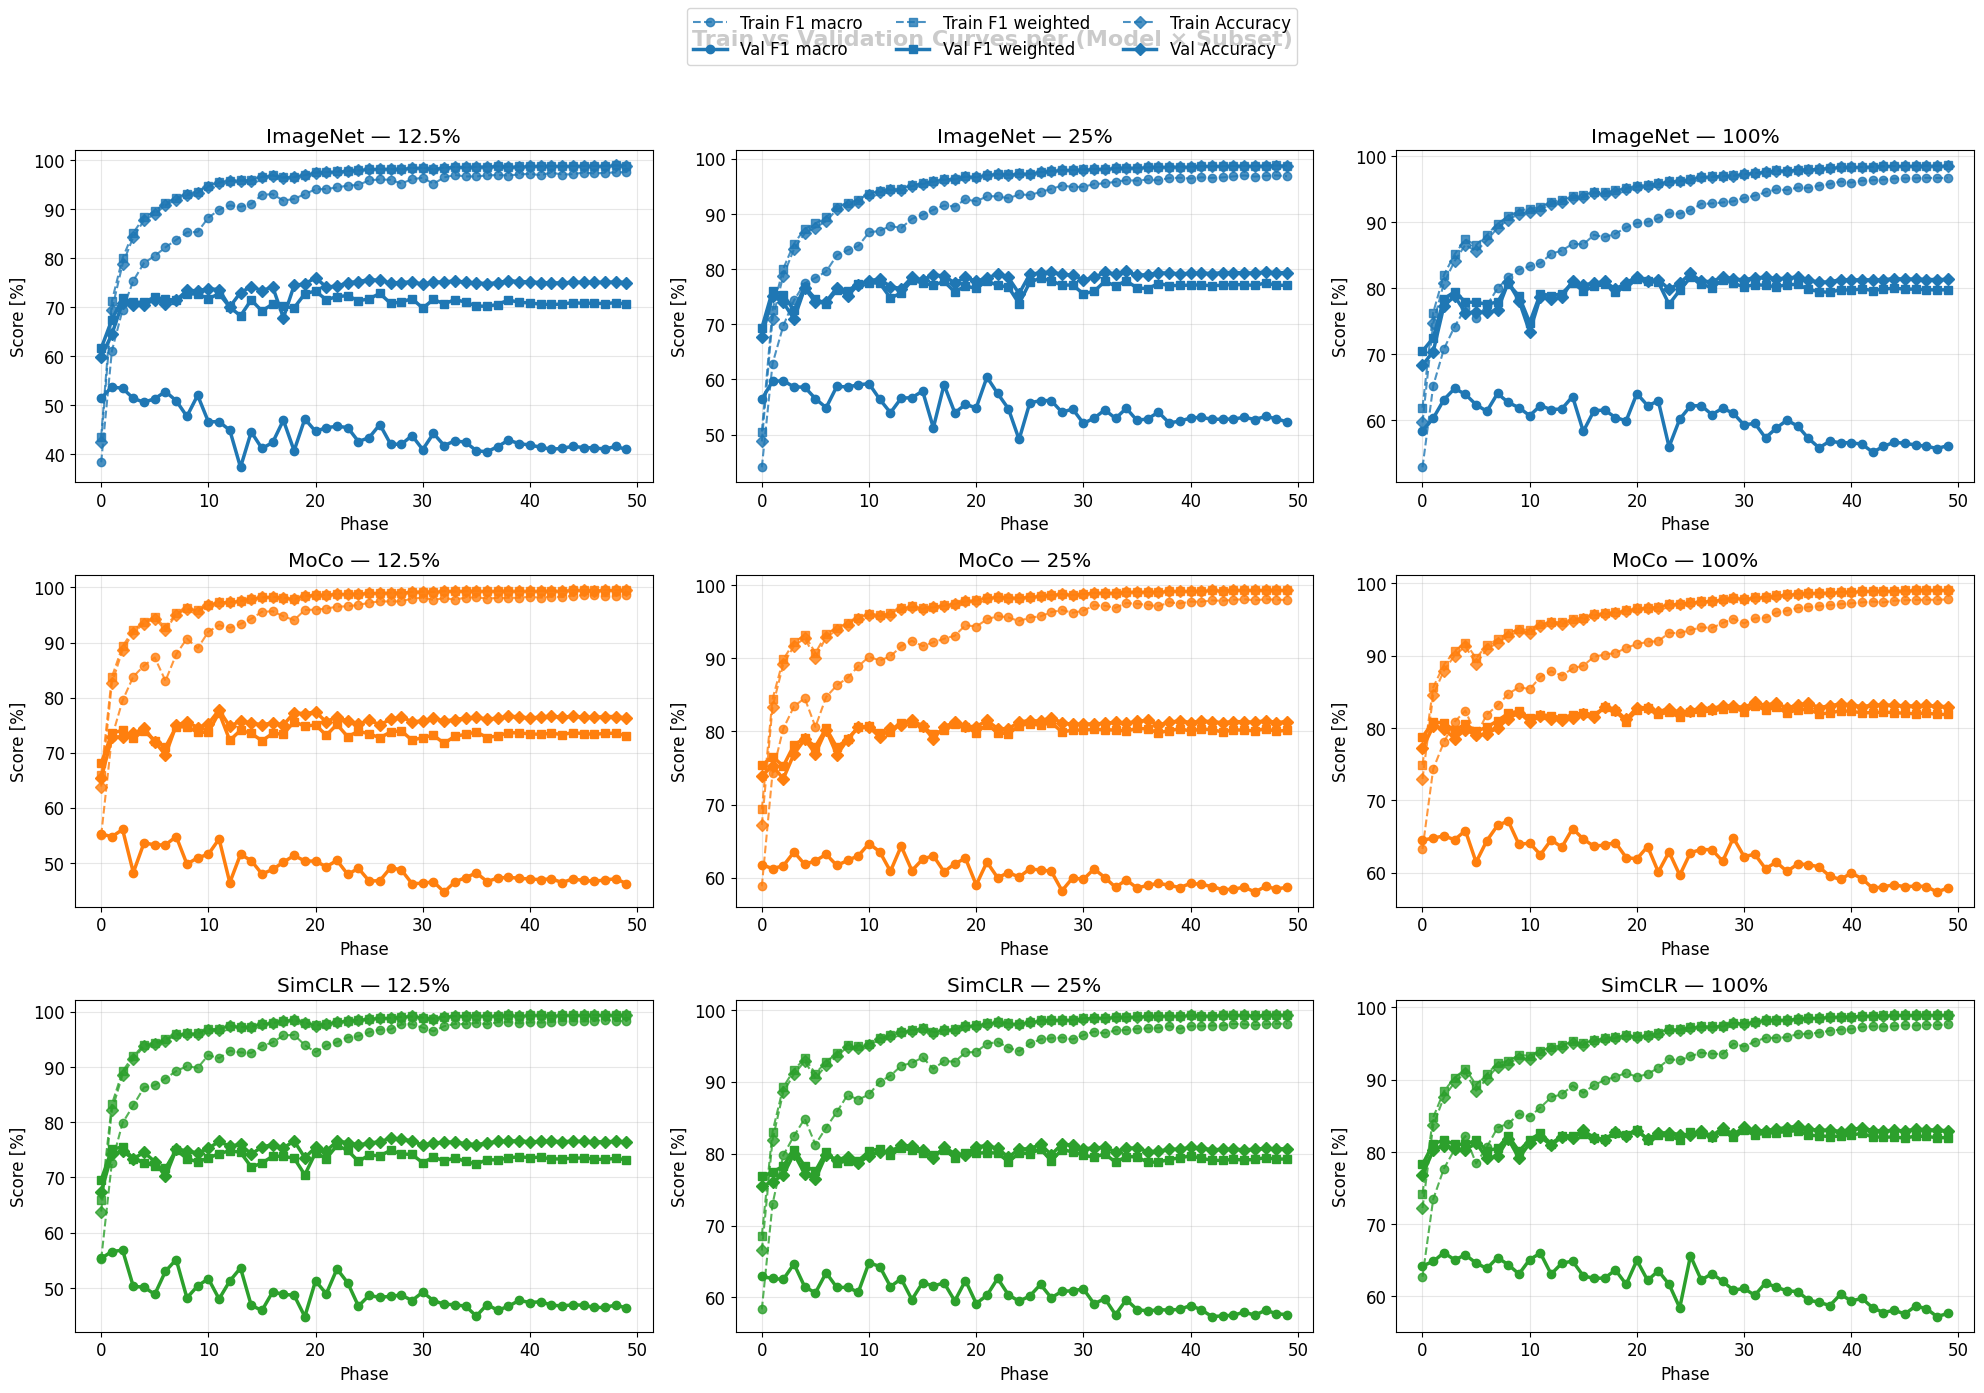

In [12]:
# === 3×3 GRID: Train vs Val curves per (Model × Subset), using existing df_all ===
import matplotlib.pyplot as plt
import numpy as np

# stałe kolory per model (jak wcześniej)
MODEL_COLORS = {"ImageNet": "#1f77b4", "MoCo": "#ff7f0e", "SimCLR": "#2ca02c"}

models_order = ["ImageNet", "MoCo", "SimCLR"]
subsets_order = ["12.5%", "25%", "100%"]

linestyles = {"train": "--", "val": "-"}
markers = {"macro": "o", "weighted": "s", "accuracy": "D"}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 14), sharex=False, sharey=False)

for i, model in enumerate(models_order):
    for j, subset in enumerate(subsets_order):
        ax = axes[i, j]
        g = df_all[(df_all["model"] == model) & (df_all["data_subset"] == subset)].sort_values("phase")
        color = MODEL_COLORS.get(model, None)

        if g.empty:
            ax.set_title(f"{model} — {subset}\n(no data)")
            ax.axis("off")
            continue

        # 6 linii: Train/Val × (macro/weighted/accuracy)
        ax.plot(g["phase"], g["train_f1_macro"],    linestyle=linestyles["train"], marker=markers["macro"],
                alpha=0.8, label="Train F1 macro", color=color)
        ax.plot(g["phase"], g["val_f1_macro"],      linestyle=linestyles["val"], marker=markers["macro"],
                linewidth=2.5, label="Val F1 macro", color=color)

        ax.plot(g["phase"], g["train_f1_weighted"], linestyle=linestyles["train"], marker=markers["weighted"],
                alpha=0.8, label="Train F1 weighted", color=color)
        ax.plot(g["phase"], g["val_f1_weighted"],   linestyle=linestyles["val"], marker=markers["weighted"],
                linewidth=2.5, label="Val F1 weighted", color=color)

        ax.plot(g["phase"], g["train_accuracy"],    linestyle=linestyles["train"], marker=markers["accuracy"],
                alpha=0.8, label="Train Accuracy", color=color)
        ax.plot(g["phase"], g["val_accuracy"],      linestyle=linestyles["val"], marker=markers["accuracy"],
                linewidth=2.5, label="Val Accuracy", color=color)

        ax.set_title(f"{model} — {subset}")
        ax.set_xlabel("Phase")
        ax.set_ylabel("Score [%]")
        ax.grid(True, alpha=0.3)

# Jedna wspólna legenda poza siatką (unikamy powtarzania)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=True)
fig.suptitle("Train vs Validation Curves per (Model × Subset)", fontsize=16, fontweight="bold", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [13]:
df_train_val

,model,data_subset,job_directory,job_path,checkpoint_path,checkpoint_exists,best_phase,best_train_phase,val_f1_macro,val_f1_weighted,val_accuracy,train_f1_macro,train_f1_weighted,train_accuracy
0,ImageNet,12.5%,job_1952602_20251015_1437,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,3,1,53.743988,67.475332,64.5076,61.091678,71.279165,69.5220
1,ImageNet,25%,job_1952603_20251015_1437,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,43,21,60.420523,77.857857,78.3905,93.175345,97.066898,96.9955
2,ImageNet,100%,job_1952604_20251015_1437,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,7,3,64.809127,79.446512,78.7604,74.177257,85.108709,84.0884
3,MoCo,12.5%,job_1953621_20251016_1141,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,5,2,56.055963,74.060891,72.9294,79.487870,89.353593,88.6579
4,MoCo,25%,job_1953622_20251016_1141,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,21,10,64.665731,80.777248,80.6107,90.218185,96.054393,95.8923
5,MoCo,100%,job_1953627_20251016_1145,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,17,8,67.114631,82.013263,81.2507,84.667293,93.083358,92.6894
6,SimCLR,12.5%,job_1952103_20251015_0322,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,5,2,56.839550,75.507024,74.7362,79.870168,89.250412,88.6037
7,SimCLR,25%,job_1952104_20251015_0322,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,21,10,64.832185,80.352568,79.7331,88.233325,95.294949,95.0455
8,SimCLR,100%,job_1952105_20251015_0322,/net/tscratch/people/plgjmachali/surgvu_result...,/net/tscratch/people/plgjmachali/surgvu_result...,True,5,2,66.040090,81.622776,80.8663,77.692975,88.406387,87.5738


## 3. Test Set Results Visualization

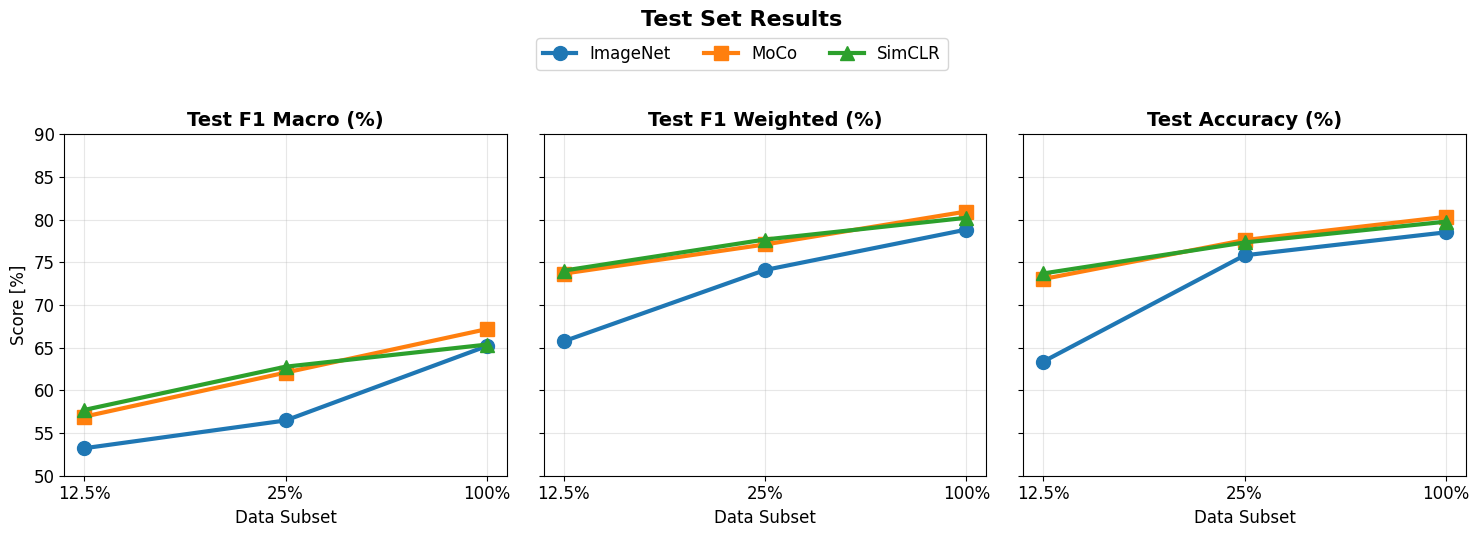

In [14]:
# === Visualization of test results (consistent markers per model) ===
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Stałe markery per model
model_markers = {
    "ImageNet": "o",
    "MoCo": "s",
    "SimCLR": "^"
}

# Wspólne zakresy
Y_MIN, Y_MAX = 50, 90
Y_TICKS = np.arange(Y_MIN, Y_MAX + 1, 5)
subset_order = ["12.5%", "25%", "100%"]

dfp = df_test_clean.copy()
dfp["data_subset"] = pd.Categorical(dfp["data_subset"], categories=subset_order, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

# List of metrics to plot
metrics = [
    ("test_f1_macro",    "Test F1 Macro (%)"),
    ("test_f1_weighted", "Test F1 Weighted (%)"),
    ("test_accuracy",    "Test Accuracy (%)")
]

for ax, (metric, title) in zip(axes, metrics):
    for model, g in dfp.groupby("model"):
        g = g.sort_values("data_subset")
        ax.plot(
            g["data_subset"], g[metric],
            marker=model_markers[model], linewidth=3, markersize=10,
            label=model, color=model_colors[model]
        )
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Data Subset")
    ax.grid(True, alpha=0.3)

# Oś Y
axes[0].set_ylabel("Score [%]")
for ax in axes:
    ax.set_ylim(Y_MIN, Y_MAX)
    ax.set_yticks(Y_TICKS)

# Oś X
for ax in axes:
    ax.set_xticks(subset_order)

# Jedna legenda
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=True, bbox_to_anchor=(0.5, 1.03))

plt.suptitle("Test Set Results", fontsize=16, fontweight="bold", y=1.07)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [15]:
dfp

,model,data_subset,phase,test_f1_macro,test_f1_weighted,test_accuracy
0,ImageNet,12.5%,0,53.222131,65.754207,63.3804
1,ImageNet,25%,0,56.474658,74.104327,75.8246
2,ImageNet,100%,0,65.188500,78.838536,78.5186
3,MoCo,12.5%,0,56.920143,73.685535,73.0514
4,MoCo,25%,0,62.085538,77.095946,77.6118
5,MoCo,100%,0,67.176518,80.956114,80.3307
6,SimCLR,12.5%,0,57.711273,74.034684,73.7025
7,SimCLR,25%,0,62.774589,77.676492,77.3293
8,SimCLR,100%,0,65.364192,80.222635,79.7666


In [16]:
def compute_all_margins(df):
    subsets = df["data_subset"].unique()
    rows = []
    for subset in subsets:
        row = {"data_subset": subset}
        for metric in ["test_f1_macro", "test_f1_weighted", "test_accuracy"]:
            pivot = df.pivot(index="data_subset", columns="model", values=metric)
            row[f"{metric}_MoCo-ImageNet"] = pivot.loc[subset, "MoCo"] - pivot.loc[subset, "ImageNet"]
            row[f"{metric}_SimCLR-ImageNet"] = pivot.loc[subset, "SimCLR"] - pivot.loc[subset, "ImageNet"]
        rows.append(row)

    return pd.DataFrame(rows)

margin_table = compute_all_margins(dfp)
margin_table

,data_subset,test_f1_macro_MoCo-ImageNet,test_f1_macro_SimCLR-ImageNet,test_f1_weighted_MoCo-ImageNet,test_f1_weighted_SimCLR-ImageNet,test_accuracy_MoCo-ImageNet,test_accuracy_SimCLR-ImageNet
0,12.5%,3.698012,4.489142,7.931328,8.280477,9.6710,10.3221
1,25%,5.610880,6.299931,2.991619,3.572165,1.7872,1.5047
2,100%,1.988018,0.175692,2.117578,1.384099,1.8121,1.2480


Across all models, performance on the test set consistently increases as the proportion of labeled training data grows from 12.5% to 25% and 100%, confirming that all approaches benefit from additional supervision. Self-supervised models (MoCo and SimCLR) outperform the ImageNet-initialized baseline across all data scales and evaluation metrics (F1 Macro, F1 Weighted, and Accuracy). SSL methods demonstrate a clear advantage in settings with limited labeled data: for example, at 12.5% of the training data, both MoCo and SimCLR exceed the performance of ImageNet on all metrics. Moreover, for F1 Macro, both SSL models trained on 12.5% of the data surpass the ImageNet model trained on 25%, indicating that comparable or superior performance can be achieved with twice fewer labeled samples. For F1 Weighted, MoCo and SimCLR at 12.5% achieve results that are essentially on par with ImageNet at 25%, reflecting a substantial label-efficiency benefit of SSL. As the dataset size increases to 100%, the performance gap between models narrows, with ImageNet reducing but not closing the gap entirely, indicating that SSL retains an advantage even under full supervision.
Overall, the results highlight the practical relevance of SSL pretraining in annotation-constrained medical scenarios, where even limited labeled data can yield performance that matches or surpasses that of supervised pretraining.


TODO: uporzadkowac markery i kolory, zakres gridu

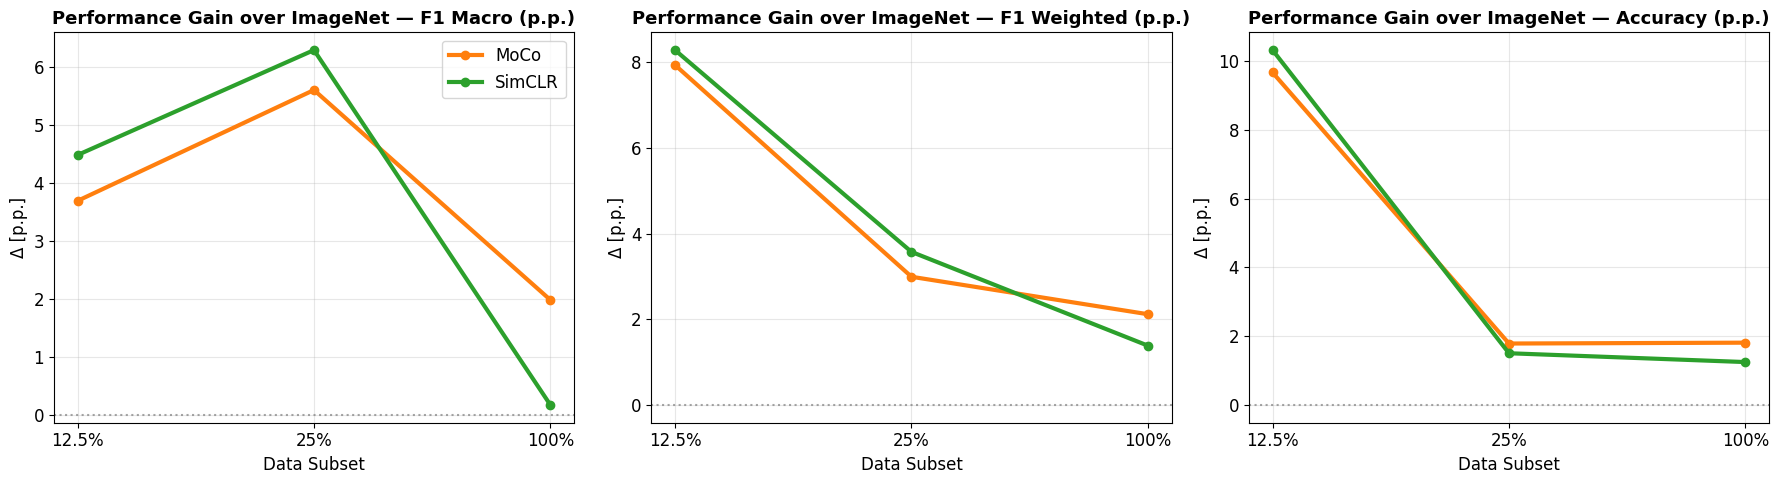

In [17]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

# safety copy + porządkowanie subsetów
df = df_test_clean.copy()

def subset_to_float(x):
    m = re.search(r"[\d\.]+", str(x))
    return float(m.group()) if m else np.nan

df["subset_num"] = df["data_subset"].apply(subset_to_float)
df = df.sort_values(["subset_num","model"])

# wyciągnij baseline (ImageNet) per subset
base = (df[df["model"]=="ImageNet"]
        .set_index("data_subset")[["test_f1_macro","test_f1_weighted","test_accuracy"]]
        .rename(columns={"test_f1_macro":"base_macro",
                         "test_f1_weighted":"base_weighted",
                         "test_accuracy":"base_acc"}))

df = df.join(base, on="data_subset")

# policz delty p.p.
df["delta_macro"]    = df["test_f1_macro"]    - df["base_macro"]
df["delta_weighted"] = df["test_f1_weighted"] - df["base_weighted"]
df["delta_acc"]      = df["test_accuracy"]    - df["base_acc"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)
plots = [
    ("delta_macro",    "Performance Gain over ImageNet — F1 Macro (p.p.)"),
    ("delta_weighted", "Performance Gain over ImageNet — F1 Weighted (p.p.)"),
    ("delta_acc",      "Performance Gain over ImageNet — Accuracy (p.p.)"),
]
for ax, (col, title) in zip(axes, plots):
    for model, g in df.groupby("model"):
        if model == "ImageNet":  # baseline to linia 0
            continue
        g = g.sort_values("subset_num")
        ax.plot(g["data_subset"], g[col], marker="o", linewidth=3, label=model,
                color=model_colors.get(model, None))
    ax.axhline(0, ls=":", color="gray", alpha=0.7)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_xlabel("Data Subset"); ax.set_ylabel("Δ [p.p.]")
    ax.grid(True, alpha=0.3)
axes[0].legend()
plt.tight_layout(); plt.show()

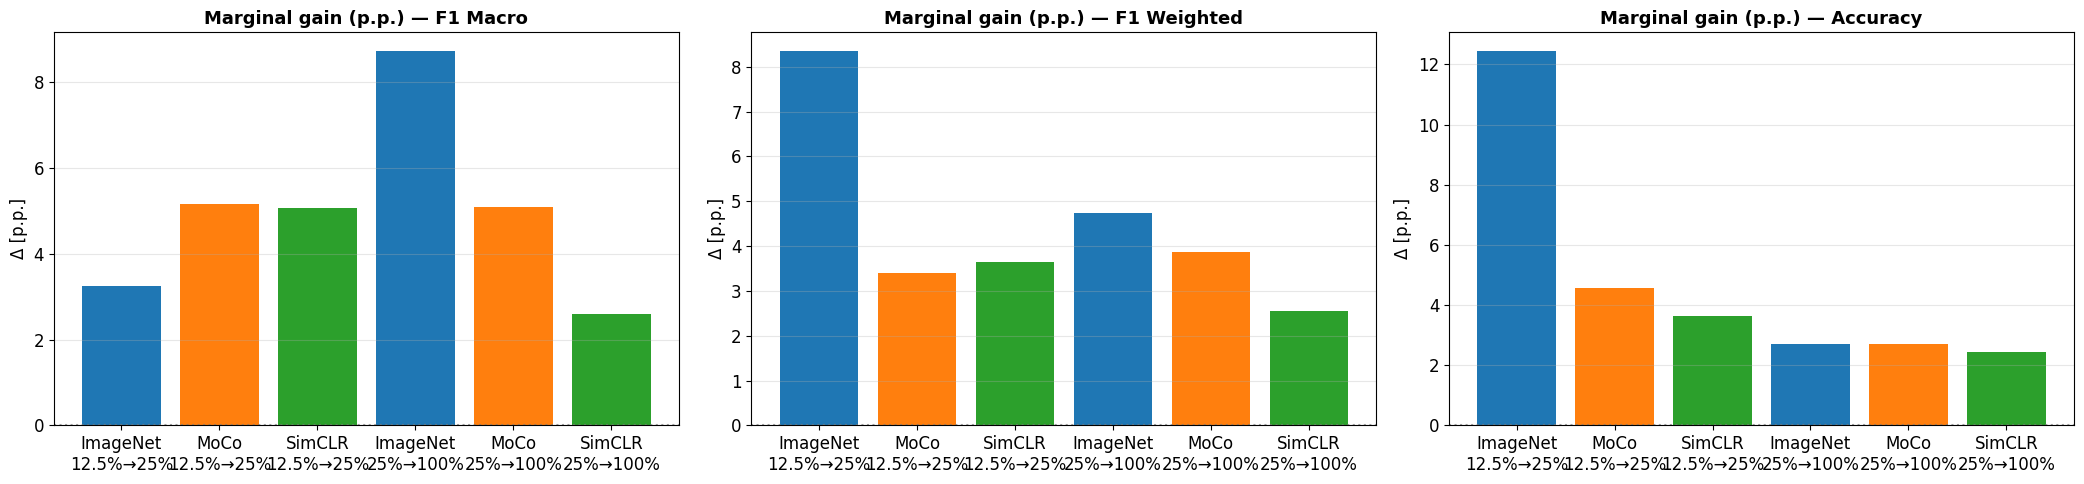

In [18]:
# przygotuj listę przejść (z posortowanego porządku subsetów)
ordered_subsets = df.sort_values("subset_num")["data_subset"].drop_duplicates().tolist()
transitions = list(zip(ordered_subsets[:-1], ordered_subsets[1:]))

def marginal_gains(df_metric, metric_col):
    out = []
    for model, g in df_metric.groupby("model"):
        g = g.sort_values("subset_num")
        vals = g[["data_subset","subset_num",metric_col]].reset_index(drop=True)
        for i in range(1, len(vals)):
            out.append({
                "model": model,
                "from": vals.loc[i-1,"data_subset"],
                "to":   vals.loc[i,"data_subset"],
                "gain_pp": vals.loc[i, metric_col] - vals.loc[i-1, metric_col]
            })
    return pd.DataFrame(out)

mg_macro    = marginal_gains(df, "test_f1_macro")
mg_weighted = marginal_gains(df, "test_f1_weighted")
mg_acc      = marginal_gains(df, "test_accuracy")

fig, axes = plt.subplots(1, 3, figsize=(21, 5))
for ax, mg, title in [
    (axes[0], mg_macro,    "Marginal gain (p.p.) — F1 Macro"),
    (axes[1], mg_weighted, "Marginal gain (p.p.) — F1 Weighted"),
    (axes[2], mg_acc,      "Marginal gain (p.p.) — Accuracy"),
]:
    x_labels, heights, colors = [], [], []
    for (frm,to) in transitions:
        gg = mg[(mg["from"]==frm) & (mg["to"]==to)]
        for _, r in gg.iterrows():
            x_labels.append(f'{r["model"]}\n{frm}→{to}')
            heights.append(r["gain_pp"])
            colors.append(model_colors.get(r["model"], None))
    ax.bar(x_labels, heights, color=colors)
    ax.axhline(0, ls=":", color="gray", alpha=0.7)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_ylabel("Δ [p.p.]")
    ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

In [19]:
# Tabela zwycięzców per subset dla trzech metryk
def winners(df_metric, metric):
    idx = df_metric.groupby("data_subset")[metric].idxmax()
    return (df_metric.loc[idx, ["data_subset","model",metric]]
            .sort_values("data_subset")
            .reset_index(drop=True))

w_macro    = winners(df, "test_f1_macro")
w_weighted = winners(df, "test_f1_weighted")
w_acc      = winners(df, "test_accuracy")

print("Winners — F1 Macro:\n",    w_macro.to_string(index=False))
print("\nWinners — F1 Weighted:\n", w_weighted.to_string(index=False))
print("\nWinners — Accuracy:\n",    w_acc.to_string(index=False))

# # (Opcjonalnie) Heatmapa wyników (bez seaborn)
# metrics = ["test_f1_macro", "test_f1_weighted", "test_accuracy"]
# for metric in metrics:
#     pivot = (df.pivot_table(index="model", columns="data_subset", values=metric))
#     plt.figure(figsize=(6, 3.6))
#     im = plt.imshow(pivot.values, aspect="auto")
#     plt.colorbar(im, fraction=0.046, pad=0.04, label=metric.replace("_"," ").title()+" [%]")
#     plt.xticks(range(pivot.shape[1]), pivot.columns)
#     plt.yticks(range(pivot.shape[0]), pivot.index)
#     plt.title(f"Heatmap — {metric.replace('_',' ').title()}", fontsize=12, fontweight="bold")
#     # wartości na kafelkach
#     for i in range(pivot.shape[0]):
#         for j in range(pivot.shape[1]):
#             val = pivot.values[i, j]
#             if pd.notna(val):
#                 plt.text(j, i, f"{val:.1f}", ha="center", va="center", fontsize=9, color="white")
#     plt.tight_layout(); plt.show()

Winners — F1 Macro:
 data_subset  model  test_f1_macro
      12.5% SimCLR      57.711273
        25% SimCLR      62.774589
       100%   MoCo      67.176518

Winners — F1 Weighted:
 data_subset  model  test_f1_weighted
      12.5% SimCLR         74.034684
        25% SimCLR         77.676492
       100%   MoCo         80.956114

Winners — Accuracy:
 data_subset  model  test_accuracy
      12.5% SimCLR        73.7025
        25%   MoCo        77.6118
       100%   MoCo        80.3307


Across all data subsets and evaluation metrics, self-supervised models (MoCo and SimCLR) consistently outperform the supervised ImageNet baseline, confirming the effectiveness of SSL pretraining in low- and mid-data regimes. SimCLR achieves the best performance at 12.5% and 25% of labeled data across all metrics, demonstrating stronger label efficiency and early generalization. As the dataset size increases to 100%, MoCo surpasses all models, indicating that its representations continue to benefit from additional supervision and scale more effectively with data. Overall, these results suggest that SimCLR generalizes better with limited labeled data, while MoCo achieves higher final performance when more annotated samples are available, and both approaches provide clear advantages over supervised initialization.

In [20]:
# plt.figure(figsize=(7,7))
# for model, g in df.groupby("model"):
#     plt.scatter(g["test_f1_macro"], g["test_f1_weighted"], s=90,
#                 label=model, color=model_colors.get(model, None))
#     # adnotacje subsetów (np. "12.5%")
#     for _, r in g.iterrows():
#         plt.annotate(str(r["data_subset"]), (r["test_f1_macro"], r["test_f1_weighted"]),
#                      textcoords="offset points", xytext=(4,4), fontsize=8)
# xymin = min(df["test_f1_macro"].min(), df["test_f1_weighted"].min())
# xymax = max(df["test_f1_macro"].max(), df["test_f1_weighted"].max())
# plt.plot([xymin, xymax], [xymin, xymax], ls="--", color="gray", alpha=0.7)
# plt.xlabel("Test F1 Macro [%]"); plt.ylabel("Test F1 Weighted [%]")
# plt.title("Weighted vs Macro (Test) — imbalance view", fontsize=12, fontweight="bold")
# plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

## 4. Validation vs Test Comparison

In [21]:
# Combine data for Val vs Test comparison
# Prepare comparison data
comparison_data = []

for _, row_val in df_train_val.iterrows():
    model = row_val['model']
    subset = row_val['data_subset']
    
    # Find corresponding row in test data
    test_row = df_test_clean[(df_test_clean['model'] == model) & 
                            (df_test_clean['data_subset'] == subset)]
    
    if not test_row.empty:
        test_row = test_row.iloc[0]
        comparison_data.append({
            'model': model,
            'data_subset': subset,
            'val_f1_macro': row_val['val_f1_macro'],  # using renamed column
            'test_f1_macro': test_row['test_f1_macro'],
            'val_f1_weighted': row_val['val_f1_weighted'],  # using renamed column
            'test_f1_weighted': test_row['test_f1_weighted'], 
            'val_accuracy': row_val['val_accuracy'],  # using renamed column
            'test_accuracy': test_row['test_accuracy']
        })

df_comparison = pd.DataFrame(comparison_data)
df_comparison["data_subset"] = pd.Categorical(df_comparison["data_subset"], categories=subset_order, ordered=True)

print("📊 Prepared comparison data Val vs Test")
print(f"Shape: {df_comparison.shape}")
print("\nPreview:")
print(df_comparison.head())

📊 Prepared comparison data Val vs Test
Shape: (9, 8)

Preview:
      model data_subset  val_f1_macro  test_f1_macro  val_f1_weighted  \
0  ImageNet       12.5%     53.743988      53.222131        67.475332   
1  ImageNet         25%     60.420523      56.474658        77.857857   
2  ImageNet        100%     64.809127      65.188500        79.446512   
3      MoCo       12.5%     56.055963      56.920143        74.060891   
4      MoCo         25%     64.665731      62.085538        80.777248   

   test_f1_weighted  val_accuracy  test_accuracy  
0         65.754207       64.5076        63.3804  
1         74.104327       78.3905        75.8246  
2         78.838536       78.7604        78.5186  
3         73.685535       72.9294        73.0514  
4         77.095946       80.6107        77.6118  


/var/folders/nn/wgfdstcd2pzfr_9_qp89s5zc0000gp/T/ipykernel_61870/4212115425.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


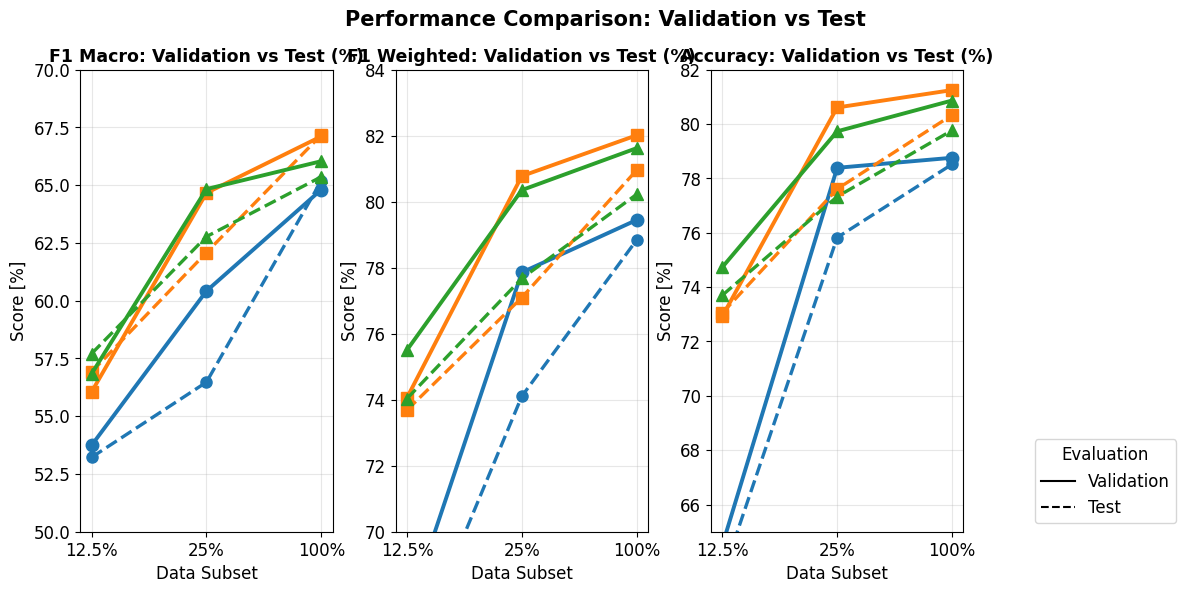

In [22]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

subset_order = ["12.5%", "25%", "100%"]
dfc = df_comparison.copy()
dfc["data_subset"] = pd.Categorical(dfc["data_subset"], categories=subset_order, ordered=True)

model_colors  = {"ImageNet": "#1f77b4", "MoCo": "#ff7f0e", "SimCLR": "#2ca02c"}
model_markers = {"ImageNet": "o", "MoCo": "s", "SimCLR": "^"}
YLIMS = {"macro": (50, 70), "weighted": (70, 84), "acc": (65, 82)}

titles = [
    ("F1 Macro: Validation vs Test (%)", "val_f1_macro", "test_f1_macro", YLIMS["macro"]),
    ("F1 Weighted: Validation vs Test (%)", "val_f1_weighted", "test_f1_weighted", YLIMS["weighted"]),
    ("Accuracy: Validation vs Test (%)", "val_accuracy", "test_accuracy", YLIMS["acc"]),
]

# --- Figure: 3 wykresy + 1 wąska kolumna na legendę ---
fig = plt.figure(figsize=(14, 6))
gs  = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.55], wspace=0.28)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
ax_leg = fig.add_subplot(gs[0, 3])
ax_leg.axis("off")  # panel tylko na legendy

for ax, (title, val_col, test_col, ylim) in zip(axes, titles):
    for model, g in dfc.groupby("model"):
        g = g.sort_values("data_subset")
        ax.plot(g["data_subset"], g[val_col],  "-",  marker=model_markers[model],
                linewidth=2.8, markersize=9, color=model_colors[model])
        ax.plot(g["data_subset"], g[test_col], "--", marker=model_markers[model],
                linewidth=2.4, markersize=8, color=model_colors[model])
    ax.set_title(title, fontsize=12.5, fontweight="bold")
    ax.set_xlabel("Data Subset"); ax.set_ylabel("Score [%]")
    ax.set_ylim(*ylim); ax.grid(True, alpha=0.3)
    ax.set_xticks(subset_order)

# --- Legendy w bocznym panelu (nie nachodzą na tytuł) ---
model_handles = [Line2D([0],[0], color=model_colors[m], marker=model_markers[m],
                        linestyle='', markersize=9, label=m)
                 for m in ["ImageNet","MoCo","SimCLR"]]
style_handles = [
    Line2D([0],[0], color="black", linestyle='-',  label="Validation"),
    Line2D([0],[0], color="black", linestyle='--', label="Test"),
]

ax_leg.legend(handles=model_handles, loc="upper left", title="Model", frameon=True)
ax_leg.legend(handles=style_handles, loc="lower left", title="Evaluation", frameon=True)
# zachowaj pierwszą legendę
for leg in fig.legends: leg.remove()  # upewnij się, że nie ma legend fig-level

fig.suptitle("Performance Comparison: Validation vs Test", fontsize=15, fontweight="bold", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

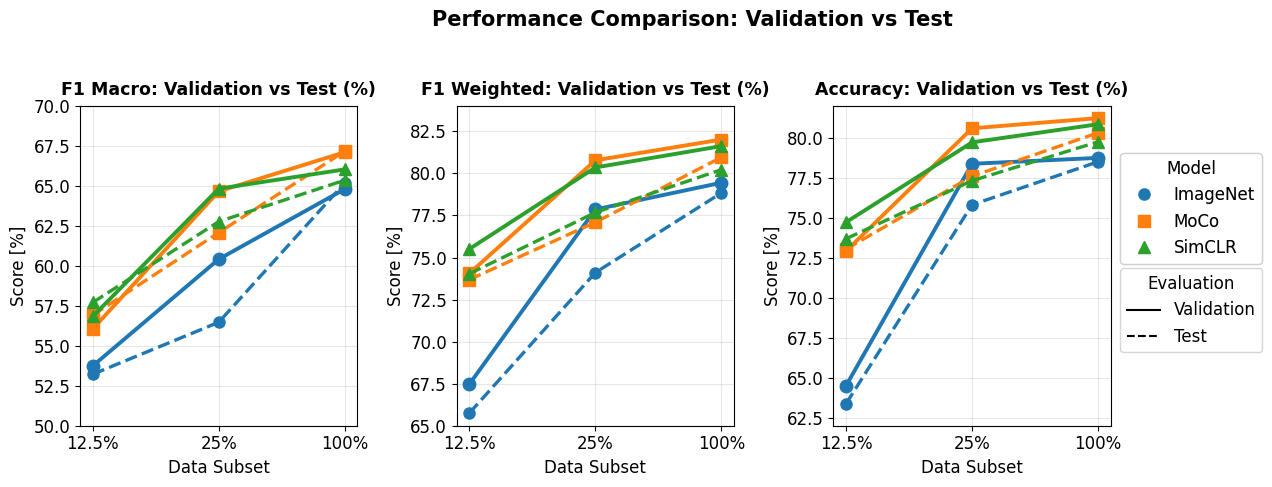

In [23]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

subset_order = ["12.5%", "25%", "100%"]
dfc = df_comparison.copy()
dfc["data_subset"] = pd.Categorical(dfc["data_subset"], categories=subset_order, ordered=True)

model_colors  = {"ImageNet": "#1f77b4", "MoCo": "#ff7f0e", "SimCLR": "#2ca02c"}
model_markers = {"ImageNet": "o", "MoCo": "s", "SimCLR": "^"}
YLIMS = {"macro": (50, 70), "weighted": (65, 84), "acc": (62, 82)}

titles = [
    ("F1 Macro: Validation vs Test (%)", "val_f1_macro", "test_f1_macro", YLIMS["macro"]),
    ("F1 Weighted: Validation vs Test (%)", "val_f1_weighted", "test_f1_weighted", YLIMS["weighted"]),
    ("Accuracy: Validation vs Test (%)", "val_accuracy", "test_accuracy", YLIMS["acc"]),
]

# --- Figure ---
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
plt.subplots_adjust(right=0.8, top=0.9, wspace=0.25)

# --- Wykresy ---
for ax, (title, val_col, test_col, ylim) in zip(axes, titles):
    for model, g in dfc.groupby("model"):
        g = g.sort_values("data_subset")
        ax.plot(g["data_subset"], g[val_col], "-", marker=model_markers[model],
                linewidth=2.8, markersize=9, color=model_colors[model])
        ax.plot(g["data_subset"], g[test_col], "--", marker=model_markers[model],
                linewidth=2.4, markersize=8, color=model_colors[model])
    ax.set_title(title, fontsize=12.5, fontweight="bold", pad=8)
    ax.set_xlabel("Data Subset")
    ax.set_ylabel("Score [%]")
    ax.set_ylim(*ylim)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(subset_order)

# --- Legendy po prawej, jedna pod drugą ---
model_handles = [Line2D([0],[0], color=model_colors[m], marker=model_markers[m],
                        linestyle='', markersize=8, label=m)
                 for m in ["ImageNet","MoCo","SimCLR"]]
style_handles = [
    Line2D([0],[0], color="black", linestyle='-',  label="Validation"),
    Line2D([0],[0], color="black", linestyle='--', label="Test"),
]

# Większy odstęp pionowy między legendami
leg1 = fig.legend(handles=model_handles, loc="upper left",
                  bbox_to_anchor=(0.80, 0.7), frameon=True, title="Model")
leg2 = fig.legend(handles=style_handles, loc="upper left",
                  bbox_to_anchor=(0.80, 0.47), frameon=True, title="Evaluation")

fig.add_artist(leg1)

# --- Tytuł ---
fig.suptitle("Performance Comparison: Validation vs Test", fontsize=15, fontweight="bold", y=0.97)
plt.tight_layout(rect=[0, 0, 0.82, 0.94])
plt.show()

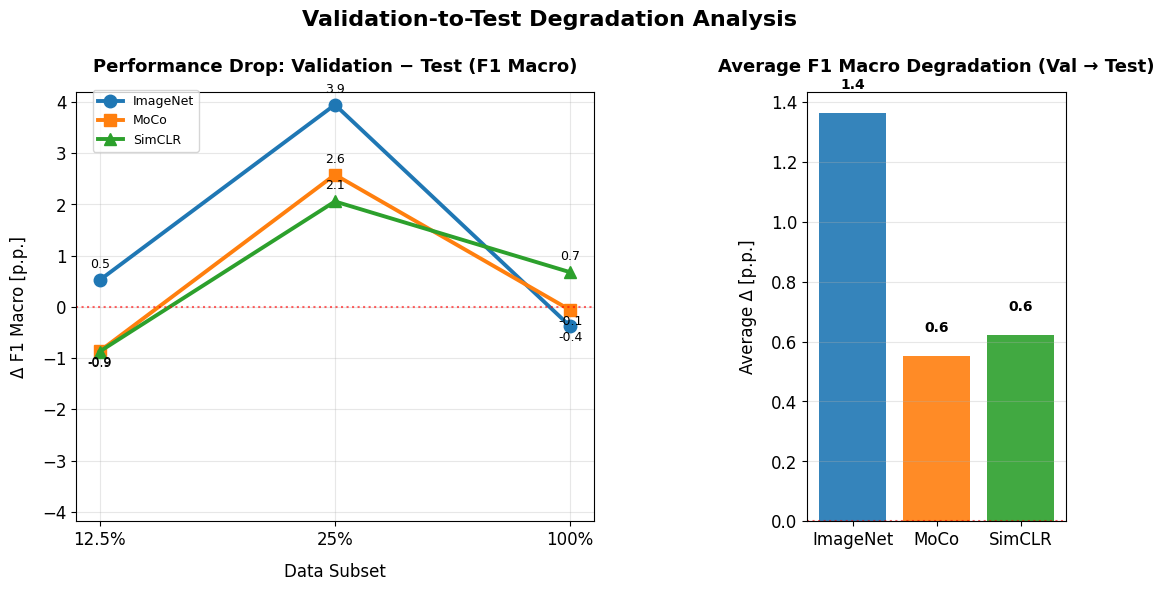

In [24]:
plt.figure(figsize=(11, 5.5))
gs = plt.GridSpec(1, 2, width_ratios=[2.2, 1.1], wspace=0.55)

# --- (1) Performance Drop per Subset ---
ax1 = plt.subplot(gs[0])
for model, g in df_comparison.groupby("model"):
    g = g.sort_values("data_subset")
    drop = g["val_f1_macro"].values - g["test_f1_macro"].values
    ax1.plot(g["data_subset"], drop,
             marker=model_markers[model],
             linewidth=2.8, markersize=9,
             color=model_colors[model],
             label=model)
    for x, v in zip(g["data_subset"], drop):
        ax1.text(x, v + (0.18 if v >= 0 else -0.35),
                 f"{v:.1f}", ha="center", va="bottom", fontsize=9)
ax1.axhline(0, linestyle=":", color="red", alpha=0.6)
ax1.set_title("Performance Drop: Validation − Test (F1 Macro)",
              fontsize=13, fontweight="bold", pad=15)  # większy odstęp od tytułu głównego
ax1.set_xlabel("Data Subset", labelpad=10)
ax1.set_ylabel("Δ F1 Macro [p.p.]", labelpad=10)
yabs = max(abs(ax1.get_ybound()[0]), abs(ax1.get_ybound()[1]), 4)
ax1.set_ylim(-yabs, yabs)
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=True, fontsize=9, loc="upper left", bbox_to_anchor=(0.02, 1.02))
ax1.set_xticks(subset_order)

# --- (2) Average degradation per model ---
ax2 = plt.subplot(gs[1])
avg_drop = (df_comparison["val_f1_macro"] - df_comparison["test_f1_macro"]).groupby(df_comparison["model"]).mean()
bars = ax2.bar(avg_drop.index, avg_drop.values,
               color=[model_colors[m] for m in avg_drop.index], alpha=0.9)
for b, v in zip(bars, avg_drop.values):
    ax2.text(b.get_x() + b.get_width()/2, v + (0.07 if v >= 0 else -0.25),
             f"{v:.1f}", ha="center", va="bottom", fontweight="bold", fontsize=10)
ax2.axhline(0, linestyle=":", color="red", alpha=0.6)
ax2.set_title("Average F1 Macro Degradation (Val → Test)",
              fontsize=13, fontweight="bold", pad=15)  # większy odstęp
ax2.set_ylabel("Average Δ [p.p.]", labelpad=10)
ax2.grid(True, axis="y", alpha=0.3)

# --- Layout tuning ---
plt.suptitle("Validation-to-Test Degradation Analysis",
             fontsize=16, fontweight="bold", y=1.05)  # zwiększony odstęp w pionie
plt.subplots_adjust(left=0.07, right=0.97, top=0.9, bottom=0.12, wspace=0.55)
plt.show()

In [25]:
# Detailed numerical comparisons for LLM analysis
print("="*80)
print("📊 DETAILED COMPARISON ANALYSIS - VALIDATION vs TEST PERFORMANCE")
print("="*80)

print("\n🔸 1. INDIVIDUAL MODEL PERFORMANCE BY DATA SUBSET:")
print("-"*60)

for subset in subset_order:
    print(f"\n📈 DATA SUBSET: {subset}")
    print("="*40)
    
    subset_comparison = df_comparison[df_comparison["data_subset"] == subset]
    
    for _, row in subset_comparison.iterrows():
        model = row["model"]
        val_f1 = row["val_f1_macro"]
        test_f1 = row["test_f1_macro"]
        degradation = val_f1 - test_f1
        
        val_f1_weighted = row["val_f1_weighted"]
        test_f1_weighted = row["test_f1_weighted"]
        degradation_weighted = val_f1_weighted - test_f1_weighted
        
        val_acc = row["val_accuracy"]
        test_acc = row["test_accuracy"]
        degradation_acc = val_acc - test_acc
        
        print(f"\n{model}:")
        print(f"  F1 Macro:     Val={val_f1:.2f}%  Test={test_f1:.2f}%  Drop={degradation:.2f}pp")
        print(f"  F1 Weighted:  Val={val_f1_weighted:.2f}%  Test={test_f1_weighted:.2f}%  Drop={degradation_weighted:.2f}pp")
        print(f"  Accuracy:     Val={val_acc:.2f}%  Test={test_acc:.2f}%  Drop={degradation_acc:.2f}pp")

print("\n\n🔸 2. CROSS-MODEL COMPARISON BY METRIC:")
print("-"*60)

# F1 Macro comparison
print(f"\n📊 F1 MACRO COMPARISON:")
print("Model".ljust(12) + "12.5% Val".ljust(12) + "12.5% Test".ljust(12) + "25% Val".ljust(12) + "25% Test".ljust(12) + "100% Val".ljust(12) + "100% Test".ljust(12))
print("-" * 84)

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model].sort_values("data_subset")
    line = model.ljust(12)
    
    for _, row in model_data.iterrows():
        line += f"{row['val_f1_macro']:.1f}".ljust(12)
        line += f"{row['test_f1_macro']:.1f}".ljust(12)
    
    print(line)

# F1 Weighted comparison
print(f"\n📊 F1 WEIGHTED COMPARISON:")
print("Model".ljust(12) + "12.5% Val".ljust(12) + "12.5% Test".ljust(12) + "25% Val".ljust(12) + "25% Test".ljust(12) + "100% Val".ljust(12) + "100% Test".ljust(12))
print("-" * 84)

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model].sort_values("data_subset")
    line = model.ljust(12)
    
    for _, row in model_data.iterrows():
        line += f"{row['val_f1_weighted']:.1f}".ljust(12)
        line += f"{row['test_f1_weighted']:.1f}".ljust(12)
    
    print(line)

# Accuracy comparison
print(f"\n📊 ACCURACY COMPARISON:")
print("Model".ljust(12) + "12.5% Val".ljust(12) + "12.5% Test".ljust(12) + "25% Val".ljust(12) + "25% Test".ljust(12) + "100% Val".ljust(12) + "100% Test".ljust(12))
print("-" * 84)

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model].sort_values("data_subset")
    line = model.ljust(12)
    
    for _, row in model_data.iterrows():
        line += f"{row['val_accuracy']:.1f}".ljust(12)
        line += f"{row['test_accuracy']:.1f}".ljust(12)
    
    print(line)

print("\n\n🔸 3. PERFORMANCE DEGRADATION ANALYSIS:")
print("-"*60)

print(f"\n📉 AVERAGE DEGRADATION BY MODEL (Val → Test):")
for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model]
    
    avg_f1_drop = (model_data["val_f1_macro"] - model_data["test_f1_macro"]).mean()
    avg_f1w_drop = (model_data["val_f1_weighted"] - model_data["test_f1_weighted"]).mean()
    avg_acc_drop = (model_data["val_accuracy"] - model_data["test_accuracy"]).mean()
    
    print(f"\n{model}:")
    print(f"  F1 Macro Drop:    {avg_f1_drop:.2f} pp")
    print(f"  F1 Weighted Drop: {avg_f1w_drop:.2f} pp")
    print(f"  Accuracy Drop:    {avg_acc_drop:.2f} pp")

print(f"\n📉 DEGRADATION BY DATA SUBSET:")
for subset in subset_order:
    subset_data = df_comparison[df_comparison["data_subset"] == subset]
    
    avg_f1_drop = (subset_data["val_f1_macro"] - subset_data["test_f1_macro"]).mean()
    avg_f1w_drop = (subset_data["val_f1_weighted"] - subset_data["test_f1_weighted"]).mean()
    avg_acc_drop = (subset_data["val_accuracy"] - subset_data["test_accuracy"]).mean()
    
    print(f"\n{subset} Data:")
    print(f"  Avg F1 Macro Drop:    {avg_f1_drop:.2f} pp")
    print(f"  Avg F1 Weighted Drop: {avg_f1w_drop:.2f} pp")
    print(f"  Avg Accuracy Drop:    {avg_acc_drop:.2f} pp")

print("\n\n🔸 4. RANKING ANALYSIS:")
print("-"*60)

print(f"\n🏆 BEST MODELS BY METRIC AND SUBSET (Test Results):")

for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset]
    
    best_f1_macro = subset_data.loc[subset_data["test_f1_macro"].idxmax()]
    best_f1_weighted = subset_data.loc[subset_data["test_f1_weighted"].idxmax()]
    best_accuracy = subset_data.loc[subset_data["test_accuracy"].idxmax()]
    
    print(f"\n{subset} Data:")
    print(f"  Best F1 Macro:    {best_f1_macro['model']} ({best_f1_macro['test_f1_macro']:.2f}%)")
    print(f"  Best F1 Weighted: {best_f1_weighted['model']} ({best_f1_weighted['test_f1_weighted']:.2f}%)")
    print(f"  Best Accuracy:    {best_accuracy['model']} ({best_accuracy['test_accuracy']:.2f}%)")

print(f"\n🔄 CONSISTENCY ANALYSIS:")
print(f"Models that achieve best performance across multiple metrics/subsets:")

# Count wins per model
model_wins = {'ImageNet': 0, 'MoCo': 0, 'SimCLR': 0}

for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset]
    
    best_f1_macro_model = subset_data.loc[subset_data["test_f1_macro"].idxmax(), "model"]
    best_f1_weighted_model = subset_data.loc[subset_data["test_f1_weighted"].idxmax(), "model"]
    best_accuracy_model = subset_data.loc[subset_data["test_accuracy"].idxmax(), "model"]
    
    model_wins[best_f1_macro_model] += 1
    model_wins[best_f1_weighted_model] += 1
    model_wins[best_accuracy_model] += 1

print(f"\nTotal wins (across all metrics and subsets):")
for model, wins in sorted(model_wins.items(), key=lambda x: x[1], reverse=True):
    print(f"  {model}: {wins}/9 possible wins")

print("\n" + "="*80)
print("✅ DETAILED COMPARISON ANALYSIS COMPLETED")
print("="*80)

📊 DETAILED COMPARISON ANALYSIS - VALIDATION vs TEST PERFORMANCE

🔸 1. INDIVIDUAL MODEL PERFORMANCE BY DATA SUBSET:
------------------------------------------------------------

📈 DATA SUBSET: 12.5%

ImageNet:
  F1 Macro:     Val=53.74%  Test=53.22%  Drop=0.52pp
  F1 Weighted:  Val=67.48%  Test=65.75%  Drop=1.72pp
  Accuracy:     Val=64.51%  Test=63.38%  Drop=1.13pp

MoCo:
  F1 Macro:     Val=56.06%  Test=56.92%  Drop=-0.86pp
  F1 Weighted:  Val=74.06%  Test=73.69%  Drop=0.38pp
  Accuracy:     Val=72.93%  Test=73.05%  Drop=-0.12pp

SimCLR:
  F1 Macro:     Val=56.84%  Test=57.71%  Drop=-0.87pp
  F1 Weighted:  Val=75.51%  Test=74.03%  Drop=1.47pp
  Accuracy:     Val=74.74%  Test=73.70%  Drop=1.03pp

📈 DATA SUBSET: 25%

ImageNet:
  F1 Macro:     Val=60.42%  Test=56.47%  Drop=3.95pp
  F1 Weighted:  Val=77.86%  Test=74.10%  Drop=3.75pp
  Accuracy:     Val=78.39%  Test=75.82%  Drop=2.57pp

MoCo:
  F1 Macro:     Val=64.67%  Test=62.09%  Drop=2.58pp
  F1 Weighted:  Val=80.78%  Test=77.10%  Drop

In [26]:
print("="*80)
print("📈 ADVANCED STATISTICAL ANALYSIS FOR LLM INTERPRETATION")
print("="*80)

print("\n🔸 1. STATISTICAL SUMMARY OF PERFORMANCE GAPS:")
print("-"*60)

# Calculate overall statistics
f1_macro_gaps = df_comparison["val_f1_macro"] - df_comparison["test_f1_macro"]
f1_weighted_gaps = df_comparison["val_f1_weighted"] - df_comparison["test_f1_weighted"]
accuracy_gaps = df_comparison["val_accuracy"] - df_comparison["test_accuracy"]

print(f"\nF1 Macro (Val-Test) Gap Statistics:")
print(f"  Mean: {f1_macro_gaps.mean():.2f} pp")
print(f"  Std:  {f1_macro_gaps.std():.2f} pp")
print(f"  Min:  {f1_macro_gaps.min():.2f} pp")
print(f"  Max:  {f1_macro_gaps.max():.2f} pp")

print(f"\nF1 Weighted (Val-Test) Gap Statistics:")
print(f"  Mean: {f1_weighted_gaps.mean():.2f} pp")
print(f"  Std:  {f1_weighted_gaps.std():.2f} pp")
print(f"  Min:  {f1_weighted_gaps.min():.2f} pp")
print(f"  Max:  {f1_weighted_gaps.max():.2f} pp")

print(f"\nAccuracy (Val-Test) Gap Statistics:")
print(f"  Mean: {accuracy_gaps.mean():.2f} pp")
print(f"  Std:  {accuracy_gaps.std():.2f} pp")
print(f"  Min:  {accuracy_gaps.min():.2f} pp")
print(f"  Max:  {accuracy_gaps.max():.2f} pp")

print("\n🔸 2. DATA SCALING EFFECTS ANALYSIS:")
print("-"*60)

print(f"\nPerformance scaling with data size (Test F1 Macro):")
for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_test_clean[df_test_clean["model"] == model].sort_values("data_subset")
    scores = model_data["test_f1_macro"].values
    
    improvement_12_to_25 = scores[1] - scores[0] if len(scores) > 1 else 0
    improvement_25_to_100 = scores[2] - scores[1] if len(scores) > 2 else 0
    total_improvement = scores[-1] - scores[0] if len(scores) > 1 else 0
    
    print(f"\n{model}:")
    print(f"  12.5% → 25%:   {improvement_12_to_25:+.2f} pp ({scores[0]:.2f}% → {scores[1]:.2f}%)")
    print(f"  25% → 100%:    {improvement_25_to_100:+.2f} pp ({scores[1]:.2f}% → {scores[2]:.2f}%)")
    print(f"  Total gain:    {total_improvement:+.2f} pp ({scores[0]:.2f}% → {scores[-1]:.2f}%)")

print("\n🔸 3. OVERFITTING ANALYSIS:")
print("-"*60)

# Calculate overfitting from training data
print(f"\nOverfitting Analysis (Train - Val F1 Macro):")
for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_train_val[df_train_val["model"] == model].sort_values("data_subset")
    
    print(f"\n{model}:")
    for _, row in model_data.iterrows():
        train_f1 = row["train_f1_macro"]
        val_f1 = row["val_f1_macro"]
        overfitting = train_f1 - val_f1
        
        print(f"  {row['data_subset']} data: Train={train_f1:.2f}% Val={val_f1:.2f}% Gap={overfitting:.2f}pp")

print("\n🔸 4. RELATIVE PERFORMANCE RANKING:")
print("-"*60)

print(f"\nRank matrix by Test F1 Macro (1=best, 3=worst):")
print("Subset".ljust(12) + "ImageNet".ljust(12) + "MoCo".ljust(12) + "SimCLR".ljust(12))
print("-" * 48)

for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset].sort_values("test_f1_macro", ascending=False)
    
    # Create ranking
    ranks = {}
    for rank, (_, row) in enumerate(subset_data.iterrows(), 1):
        ranks[row["model"]] = rank
    
    line = subset.ljust(12)
    for model in ['ImageNet', 'MoCo', 'SimCLR']:
        line += str(ranks.get(model, "-")).ljust(12)
    
    print(line)

print("\n🔸 5. PERFORMANCE CONSISTENCY METRICS:")
print("-"*60)

print(f"\nCoefficient of Variation (CV) across data subsets:")
print("Lower CV = more consistent performance across different data sizes")

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_test_clean[df_test_clean["model"] == model]
    
    f1_macro_cv = (model_data["test_f1_macro"].std() / model_data["test_f1_macro"].mean()) * 100
    f1_weighted_cv = (model_data["test_f1_weighted"].std() / model_data["test_f1_weighted"].mean()) * 100
    accuracy_cv = (model_data["test_accuracy"].std() / model_data["test_accuracy"].mean()) * 100
    
    print(f"\n{model}:")
    print(f"  F1 Macro CV:    {f1_macro_cv:.2f}%")
    print(f"  F1 Weighted CV: {f1_weighted_cv:.2f}%")
    print(f"  Accuracy CV:    {accuracy_cv:.2f}%")

print("\n🔸 6. GENERALIZATION GAP ANALYSIS:")
print("-"*60)

print(f"\nGeneralization Gap (Validation vs Test) by model:")
print("Smaller gap = better generalization from validation to test")

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model]
    
    avg_f1_gap = (model_data["val_f1_macro"] - model_data["test_f1_macro"]).mean()
    std_f1_gap = (model_data["val_f1_macro"] - model_data["test_f1_macro"]).std()
    
    print(f"\n{model}:")
    print(f"  Mean F1 Macro Gap: {avg_f1_gap:.2f} ± {std_f1_gap:.2f} pp")
    
    # Show individual gaps
    for _, row in model_data.iterrows():
        gap = row["val_f1_macro"] - row["test_f1_macro"]
        print(f"    {row['data_subset']}: {gap:.2f} pp")

print("\n" + "="*80)
print("✅ ADVANCED STATISTICAL ANALYSIS COMPLETED")
print("="*80)

📈 ADVANCED STATISTICAL ANALYSIS FOR LLM INTERPRETATION

🔸 1. STATISTICAL SUMMARY OF PERFORMANCE GAPS:
------------------------------------------------------------

F1 Macro (Val-Test) Gap Statistics:
  Mean: 0.84 pp
  Std:  1.67 pp
  Min:  -0.87 pp
  Max:  3.95 pp

F1 Weighted (Val-Test) Gap Statistics:
  Mean: 1.86 pp
  Std:  1.24 pp
  Min:  0.38 pp
  Max:  3.75 pp

Accuracy (Val-Test) Gap Statistics:
  Mean: 1.36 pp
  Std:  1.07 pp
  Min:  -0.12 pp
  Max:  3.00 pp

🔸 2. DATA SCALING EFFECTS ANALYSIS:
------------------------------------------------------------

Performance scaling with data size (Test F1 Macro):

ImageNet:
  12.5% → 25%:   +3.25 pp (53.22% → 56.47%)
  25% → 100%:    +8.71 pp (56.47% → 65.19%)
  Total gain:    +11.97 pp (53.22% → 65.19%)

MoCo:
  12.5% → 25%:   +5.17 pp (56.92% → 62.09%)
  25% → 100%:    +5.09 pp (62.09% → 67.18%)
  Total gain:    +10.26 pp (56.92% → 67.18%)

SimCLR:
  12.5% → 25%:   +5.06 pp (57.71% → 62.77%)
  25% → 100%:    +2.59 pp (62.77% → 65.36

## 5. Summary Tables

In [27]:
# Summary tables
print("=" * 100)
print("📊 SUMMARY TABLE - VALIDATION RESULTS (Train/Val)")
print("=" * 100)
print(df_train_val.round(2).to_string(index=False))

print("\n" + "=" * 100)
print("📊 SUMMARY TABLE - TEST RESULTS")
print("=" * 100)
print(df_test_clean.round(2).to_string(index=False))

print("\n" + "=" * 100)
print("📊 COMPARISON TABLE - VALIDATION vs TEST")
print("=" * 100)
print(df_comparison.round(2).to_string(index=False))

📊 SUMMARY TABLE - VALIDATION RESULTS (Train/Val)
   model data_subset             job_directory                                                                                                    job_path                                                                                                                checkpoint_path  checkpoint_exists  best_phase  best_train_phase  val_f1_macro  val_f1_weighted  val_accuracy  train_f1_macro  train_f1_weighted  train_accuracy
ImageNet       12.5% job_1952602_20251015_1437  /net/tscratch/people/plgjmachali/surgvu_results/finetuning/imagenet_to_surgvu/12/job_1952602_20251015_1437  /net/tscratch/people/plgjmachali/surgvu_results/finetuning/imagenet_to_surgvu/12/job_1952602_20251015_1437/model_phase1.torch               True           3                 1         53.74            67.48         64.51           61.09              71.28           69.52
ImageNet         25% job_1952603_20251015_1437  /net/tscratch/people/plgjmachali/surgvu_results/f

In [28]:
# Best models analysis
print("\n" + "=" * 100)
print("🏆 BEST MODELS BY DATA SUBSET (by Test F1 Macro)")
print("=" * 100)

# Best on validation
print("\n🔸 VALIDATION:")
for subset in subset_order:
    subset_data = df_train_val[df_train_val["data_subset"] == subset]
    if subset_data.empty:
        continue
    best_row = subset_data.loc[subset_data["val_f1_macro"].idxmax()]
    print(f"\n{subset} Data:")
    print(f"  🥇 Best Model: {best_row['model']}")
    print(f"  📊 Val F1 Macro: {best_row['val_f1_macro']:.2f}%")
    print(f"  📊 Val F1 Weighted: {best_row['val_f1_weighted']:.2f}%")
    print(f"  📊 Val Accuracy: {best_row['val_accuracy']:.2f}%")
    print(f"  🎯 Best Phase: {int(best_row['best_phase'])}")

# Best on test
print("\n🔸 TEST:")
for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset]
    if subset_data.empty:
        continue
    best_row = subset_data.loc[subset_data["test_f1_macro"].idxmax()]
    print(f"\n{subset} Data:")
    print(f"  🥇 Best Model: {best_row['model']}")
    print(f"  📊 Test F1 Macro: {best_row['test_f1_macro']:.2f}%")
    print(f"  📊 Test F1 Weighted: {best_row['test_f1_weighted']:.2f}%")
    print(f"  📊 Test Accuracy: {best_row['test_accuracy']:.2f}%")

# Overall statistics
print("\n" + "=" * 100)
print("📈 OVERALL STATISTICS")
print("=" * 100)

print("\n🔸 AVERAGE RESULTS BY MODEL (Test F1 Macro):")
test_avg = df_test_clean.groupby("model")["test_f1_macro"].mean().sort_values(ascending=False)
for model, avg_score in test_avg.items():
    print(f"  {model}: {avg_score:.2f}%")

print("\n🔸 AVERAGE DEGRADATION VAL → TEST (F1 Macro):")
for model, group in df_comparison.groupby("model"):
    avg_degradation = (group["val_f1_macro"] - group["test_f1_macro"]).mean()
    print(f"  {model}: {avg_degradation:.2f} p.p.")

print("\n🔸 BEST OVERALL RESULT:")
overall_best = df_test_clean.loc[df_test_clean["test_f1_macro"].idxmax()]
print(f"  Model: {overall_best['model']}")
print(f"  Subset: {overall_best['data_subset']}")
print(f"  Test F1 Macro: {overall_best['test_f1_macro']:.2f}%")

print("\n✅ Analysis completed!")


🏆 BEST MODELS BY DATA SUBSET (by Test F1 Macro)

🔸 VALIDATION:

12.5% Data:
  🥇 Best Model: SimCLR
  📊 Val F1 Macro: 56.84%
  📊 Val F1 Weighted: 75.51%
  📊 Val Accuracy: 74.74%
  🎯 Best Phase: 5

25% Data:
  🥇 Best Model: SimCLR
  📊 Val F1 Macro: 64.83%
  📊 Val F1 Weighted: 80.35%
  📊 Val Accuracy: 79.73%
  🎯 Best Phase: 21

100% Data:
  🥇 Best Model: MoCo
  📊 Val F1 Macro: 67.11%
  📊 Val F1 Weighted: 82.01%
  📊 Val Accuracy: 81.25%
  🎯 Best Phase: 17

🔸 TEST:

12.5% Data:
  🥇 Best Model: SimCLR
  📊 Test F1 Macro: 57.71%
  📊 Test F1 Weighted: 74.03%
  📊 Test Accuracy: 73.70%

25% Data:
  🥇 Best Model: SimCLR
  📊 Test F1 Macro: 62.77%
  📊 Test F1 Weighted: 77.68%
  📊 Test Accuracy: 77.33%

100% Data:
  🥇 Best Model: MoCo
  📊 Test F1 Macro: 67.18%
  📊 Test F1 Weighted: 80.96%
  📊 Test Accuracy: 80.33%

📈 OVERALL STATISTICS

🔸 AVERAGE RESULTS BY MODEL (Test F1 Macro):
  MoCo: 62.06%
  SimCLR: 61.95%
  ImageNet: 58.30%

🔸 AVERAGE DEGRADATION VAL → TEST (F1 Macro):
  ImageNet: 1.36 p.p.
  